# Comprehensive comparison of models

In [1]:
import sys
import joblib
import numpy as np
sys.path.append("../lib")
from JTNNWrapper import JTNNWapper
from fp_func import fp_similarity
import random


Using backend: pytorch
RDKit WARNING: [15:43:17] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
import pandas as pd
#regression...
file_path="../database/BradleyDoublePlusGoodMeltingPointDataset_logP.csv"
target_param_name="MolLogP"
target_param_name="TPSA"
target_param_name="MP"


smiles_column="SMILES"
    
df=pd.read_csv(file_path)
df=df[[smiles_column,target_param_name]]
df=df.dropna()


smiles_list=list(df[smiles_column].values)
y_array=np.array(df[target_param_name].values)


In [3]:
vec_path="data/jtnn_vec"
#jtnn=JTNNWapper()
#vec_array=jtnn.encode(smiles_list)
#joblib.dump(vec_array,vec_path)
vec_array=joblib.load(vec_path)

In [4]:
def extra_split(df,
    target_param_name="y",
    spl_ratio=0.8,
    top_spl_ratio=0.9,
    ):

    df=df.sort_values(by=target_param_name)
    total_records=df.shape[0]

    # use top 10% rec and random10% rec for test
    top_spl_pos=int(top_spl_ratio*total_records)
    temp_df=df.sort_values(by=target_param_name)
    top_df=temp_df[top_spl_pos:]
    other_df=temp_df[:top_spl_pos].sample(frac=1,random_state=random.randint(0, 2**31))
    target_df=other_df.append(top_df)

    spl_pos=int((spl_ratio)*target_df.shape[0])

    tr_df=target_df[:spl_pos]
    te_df=target_df[spl_pos:]

    tr_X=np.array(tr_df.drop(target_param_name,axis=1))
    te_X=np.array(te_df.drop(target_param_name,axis=1))
    tr_y=np.array(tr_df[target_param_name])
    te_y=np.array(te_df[target_param_name])
    
    return tr_X,te_X,tr_y,te_y

def evaluate_model(model,data_df,plot=True):
    tr_X, te_X,tr_y,te_y = extra_split(data_df,top_spl_ratio=0.95,spl_ratio=0.9)
    
    model.fit(tr_X,tr_y)
    p_tr_y=model.predict(tr_X)
    p_te_y=model.predict(te_X)

    if plot:
        plt.figure(figsize=(4,4))
        plt.scatter(tr_y,p_tr_y,s=3)
        plt.scatter(te_y,p_te_y,s=3)

        vmax=np.max(np.concatenate([tr_y,te_y]))
        vmin=np.min(np.concatenate([tr_y,te_y]))

        plt.xlim(vmin,vmax)
        plt.ylim(vmin,vmax)

    tr_y_max=np.max(tr_y)

    extra_ids=np.where(te_y>tr_y_max)
    inner_ids=np.where(te_y<=tr_y_max)

    res_dict={}
    res_dict["te_y"]=te_y
    res_dict["tr_y"]=tr_y
    res_dict["p_te_y"]=p_te_y
    res_dict["p_tr_y"]=p_tr_y
    res_dict["p_tr_y"]=p_tr_y
    res_dict["extra_ids"]=extra_ids
    res_dict["inner_ids"]=inner_ids
    return res_dict
    
    return p_te_y,p_tr_y
    
    extra_MAE=mean_absolute_error(te_y[extra_ids],p_te_y[extra_ids])
    inner_MAE=mean_absolute_error(te_y[inner_ids],p_te_y[inner_ids])
    train_MAE=mean_absolute_error(tr_y,p_tr_y)


    #print(extra_MAE,inner_MAE,train_MAE)
    
    return extra_MAE,inner_MAE,train_MAE

In [5]:
from Fingerprint import Fingerprint


#prepare vector data df
available_ids=list(set(np.where(vec_array!=0)[0]))
vec_array=vec_array[available_ids]
y_array=y_array[available_ids]
vec_data_df=pd.DataFrame(vec_array)
vec_data_df["y"]=y_array

#prepare FP data df
FP=Fingerprint()

_,available_ids=FP.calc_fingerprint(df[smiles_column].values)
temp_df=df[available_ids]
fp_list,_=FP.calc_fingerprint(temp_df[smiles_column].values)

fp_df=pd.DataFrame(fp_list)
fp_df["y"]=temp_df[target_param_name]

In [6]:
from ScaleRegressor import ScaleRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model

from pyfm import pylibfm
from scipy.sparse import csr_matrix

from ExtraFM import ExtraFM

In [7]:
#model definition

# extra FM: not stable
"""
fm_model=ExtraFM(pylibfm.FM(task="regression", num_iter=300,initial_learning_rate=1*10**-5,
                      num_factors=10,
                   verbose=False
                    ))   
"""
# normal FM: stable
from ExtraFM import FMRegressor

fm_model=FMRegressor(model = pylibfm.FM(task="regression", num_iter=30,
                                     initial_learning_rate=10**-3,num_factors=10,
                                     verbose=False),
                    auto_scaling_X=False)
    

In [8]:
from sklearn.svm import SVR
    
    
rfr_model=ScaleRegressor(model=RandomForestRegressor())
pls_model=ScaleRegressor(model=PLSRegression(n_components=30))
lasso_model=ScaleRegressor(model=linear_model.Lasso(alpha=0.01))
bayesian_ridge_model=ScaleRegressor(model=linear_model.BayesianRidge())
svr_model=ScaleRegressor(model=SVR())

{'te_y': array([-165.  ,  151.5 ,    2.  ,  154.  ,  191.  ,   93.  ,  107.  ,
         127.  ,  174.  ,  -98.  ,   26.  ,   65.  ,  191.  ,  204.5 ,
         -65.  ,  131.5 ,  121.  ,  -88.  ,  -22.  ,   61.  ,  -62.  ,
          42.  ,  -31.  ,   68.5 ,   52.  ,   79.  ,  -91.  ,  -55.  ,
         125.  ,  188.  ,  101.  ,   50.  ,  107.  , -113.  ,   52.  ,
         171.  ,   10.  ,   99.  ,   -1.  ,  167.  , -124.  ,  136.  ,
        -112.  , -101.  ,  -13.  , -118.  ,   10.  ,   45.  ,   55.  ,
         154.5 ,  138.  ,  142.  ,  215.  ,   82.  ,   56.  ,   60.  ,
         197.  ,   92.  , -124.  ,  -93.  ,   70.  ,  153.  ,   73.  ,
          34.  ,  105.  ,   26.  ,    6.  ,  -34.  ,  140.  , -188.  ,
          12.  ,  -86.  ,   54.  ,  136.  ,   87.5 ,   58.  ,   90.  ,
          49.  ,  -80.  ,  195.  ,   59.  ,  182.  ,  127.  ,    8.  ,
          12.  ,   50.  ,  160.  ,   34.  ,  -15.  ,  135.5 ,  -19.  ,
          58.  ,   -1.  ,   72.5 ,   63.  ,  169.  ,   79.  ,   61.  

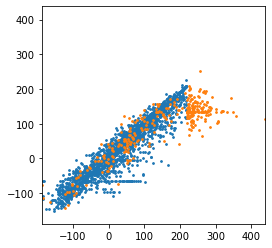

In [13]:
#r=evaluate_model(fm_model,fp_df)
evaluate_model(svr_model,fp_df)

In [14]:
#statistical analyses
from tqdm.notebook import tqdm
NUM_REPEAT=5

condition_dict={
   "PLS-vec":(pls_model,vec_data_df),
   "PLS-fp":(pls_model,fp_df),
    "Lasso-vec":(lasso_model,vec_data_df),
    "Lasso-fp":(lasso_model,fp_df),
    "Bayes-vec":(bayesian_ridge_model,vec_data_df),
    "Bayes-fp":(bayesian_ridge_model,fp_df),
    "RF-vec":(rfr_model,vec_data_df),
    "RF-fp":(rfr_model,fp_df),
    "SVR-vec":(svr_model,vec_data_df),
    "SVR-fp":(svr_model,fp_df),
    "FM-fp":(fm_model,fp_df),
}

target_param_name="MolLogP"
target_param_name="TPSA"
target_param_name="MP"

for target_param_name in ["MolLogP","TPSA","MP"]:

    res_dict={}
    for i in tqdm(range(NUM_REPEAT)):
        for name,cond in condition_dict.items():
            model=cond[0]
            dataframe=cond[1]
            r=evaluate_model(model,dataframe,plot=False)        
            r["cond"]=cond
            res_dict[f"{i}-{name}"]=r
            
        joblib.dump(res_dict,"res/20220530/"+target_param_name+".bin")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]